In [11]:
import glob
import os
# from haven import haven_utils as hu
from utils import file_utils as hu
import numpy as np
from skimage.segmentation import  find_boundaries, new_watershed,watershed
import matplotlib.pyplot as plt
import skimage.io as sio

from skimage.segmentation import find_boundaries
from skimage.filters import gaussian, sobel, scharr, difference_of_gaussians
from skimage import color
import json


In [12]:
SMOOTH = 1e-6

edge_filter = sobel

data_dir = "./CoNSeP"

mode = "Train"

In [13]:
def validate_obj_params(obj_params=dict()):
    if not type(obj_params) is dict:
        raise TypeError('The obj_params is expected to be a dictionary not a {}'.format(type(obj_params)))
    if not 'sigma' in obj_params.keys():
        obj_params['sigma'] = 0.0
    if not 'alpha' in obj_params.keys():
        obj_params['alpha'] = 1.0
    return obj_params

In [14]:
def generate_dist(image, points, obj_params=dict()):
    obj_params = validate_obj_params(obj_params)
    points = np.array(points)
    pl = np.zeros(image.shape[:2])
    if len(points)!=0:
        pl[points[0,:].round().astype(int), points[1, :].round().astype(int)] = np.arange(1, len(points[0]) + 1)
        image = gaussian(image, 2.1381697911810127,multichannel=True)  

        # offset = None
        # pad_width = [(p, p) for p in offset]
        # image0 = np.pad(image[...,0], pad_width, mode='constant')
        #     image[...,0] = edge_filter(image[...,0])
        #     image[...,1] = edge_filter(image[...,1])
        #     image[...,2] = edge_filter(image[...,2])
        #     import pdb
        #     pdb.set_trace()
        grey_img = color.rgb2gray(image)
        # return watershed(image[:,:,2], pl)
        return new_watershed(image,pl,method=True)
    else:
        return np.zeros(image.shape[:2]), np.inf*np.ones(image.shape[:2])

In [15]:
def generate_obj(image, points, obj_params=dict()):
    obj_params = validate_obj_params(obj_params)
    # reg_split,dist = generate_dist(image, points, obj_params)    
    reg_split,dist = generate_dist(image, points, obj_params)    
    bkg = find_boundaries(reg_split)
    #     dist[bkg] = np.inf
    return np.exp(-obj_params['alpha'] * dist ** 2), bkg, reg_split

In [34]:
def generate_obj_from_file(img_file, points_file, obj_params=dict()):
    obj_params = validate_obj_params(obj_params)
    img = sio.imread(img_file)[:,:,0:3]
    print(img.shape)
    points = hu.load_json(points_file)
    if type(points) is dict:
        dist = np.stack([generate_obj(img, v, obj_params) for _, v in points.items()], axis=0)
        return dist
    elif type(points) is list:
        print("It's a List")
    else:
        print("Type Error:")

    return generate_obj(img, points, obj_params=obj_params)

In [17]:
def iou_numpy(outputs: np.array, labels: np.array):
    outputs = outputs.round().astype(bool)
    labels = labels.round().astype(bool)
    intersection = (outputs & labels).sum()
    union = (outputs | labels).sum()

    iou = (intersection + SMOOTH) / (union + SMOOTH)

    return iou

In [18]:
def cross_entropy_numpy(outputs: np.array, labels: np.array):
    return np.mean(-labels * np.log(SMOOTH + outputs) - (1 - labels) * np.log(SMOOTH + 1 - outputs))

In [19]:
save_dir = os.path.join(data_dir, "Train", "Objs")
os.makedirs(save_dir, exist_ok=True)
# for train_pts in glob.glob(os.path.join(data_dir, "Train", "Pts", "*")):
test_image = "/data114_1/wzy/dataset/CoNSeP/Train/dealing/train_10_0_0.png"
test_points = "/data114_1/wzy/dataset/CoNSeP/Train/Points/train_10_0_0.json"
obj = generate_obj_from_file(test_image, test_points)

/home/wzy/.conda/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  import sys


In [20]:
obj_dir = os.path.join(data_dir,mode,'Objs')
os.makedirs(obj_dir, exist_ok=True)

bkg_dir = os.path.join(data_dir,mode,'Bkgs')
os.makedirs(bkg_dir, exist_ok=True)

img_dir = os.path.join(data_dir,mode,'Images')
os.makedirs(img_dir, exist_ok=True)

gt_dir = os.path.join(data_dir,mode,'GTs')

os.makedirs(gt_dir, exist_ok=True)

region_dir = os.path.join(data_dir,mode,'Regions')
os.makedirs(region_dir, exist_ok=True)

annotion_dir = os.path.join(data_dir,mode,'Pts')
os.makedirs(annotion_dir, exist_ok=True)

src_root = os.path.join("/data114_1/wzy/dataset/CoNSeP",mode)

In [21]:
file_paths = os.listdir(os.path.join(src_root,"Points"))
file_paths.sort()

In [25]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
for i,file_path in enumerate(file_paths):
    file_name = file_path.split('.')[0]
    img_path = os.path.join(src_root,"dealing",file_name+".png")
    ann_path = os.path.join(src_root,"Points",file_path)
    result = generate_obj_from_file(img_path,ann_path)[0]
    obj = result[0]
    bkg = result[1]
    region = result[2]
    gt=np.load(os.path.join(src_root,"dealing",file_name+"_inst.npy"))

    sio.imsave(os.path.join(img_dir,file_name+'.png'),sio.imread(img_path))
    sio.imsave(os.path.join(obj_dir,file_name+'.png'),obj)
    sio.imsave(os.path.join(bkg_dir,file_name+'.png'),bkg.astype('uint8'))
    sio.imsave(os.path.join(region_dir,file_name+'.png'),region.astype('uint8'))
    sio.imsave(os.path.join(gt_dir,file_name+'.png'),gt.astype('uint8'))

    annotion = hu.load_json(ann_path)
    with open(os.path.join(annotion_dir,file_path), "w") as json_file:
            json.dump(annotion, json_file, indent=4, sort_keys=True)
    

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_10_0_0
(256, 256, 3)
train_10_0_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_10_0_496
(256, 256, 3)
train_10_0_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_10_248_0
(256, 256, 3)
train_10_248_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_10_248_496
(256, 256, 3)
train_10_248_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_10_496_0
(256, 256, 3)
train_10_496_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_10_496_496
(256, 256, 3)
train_10_496_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_10_744_0
(256, 256, 3)
train_10_744_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_10_744_496
(256, 256, 3)
train_10_744_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_11_0_0
(256, 256, 3)
train_11_0_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_11_0_496
(256, 256, 3)
train_11_0_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_11_248_0
(256, 256, 3)
train_11_248_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_11_248_496
(256, 256, 3)
train_11_248_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_11_496_0
(256, 256, 3)
train_11_496_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_11_496_496
(256, 256, 3)
train_11_496_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_11_744_0
(256, 256, 3)
train_11_744_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_11_744_496
(256, 256, 3)
train_11_744_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_12_0_0
(256, 256, 3)
train_12_0_248
(256, 256, 3)
train_12_0_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_12_0_744
(256, 256, 3)
train_12_248_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_12_248_248
(256, 256, 3)
train_12_248_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_12_248_744
(256, 256, 3)
train_12_496_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_12_496_248
(256, 256, 3)
train_12_496_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_12_496_744
(256, 256, 3)
train_12_744_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_12_744_248
(256, 256, 3)
train_12_744_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_12_744_744
(256, 256, 3)
train_13_0_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_13_0_248
(256, 256, 3)
train_13_0_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_13_0_744
(256, 256, 3)
train_13_248_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_13_248_248
(256, 256, 3)
train_13_248_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_13_248_744
(256, 256, 3)
train_13_496_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_13_496_248
(256, 256, 3)
train_13_496_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_13_496_744
(256, 256, 3)
train_13_744_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_13_744_248
(256, 256, 3)
train_13_744_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_13_744_744
(256, 256, 3)
train_14_0_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_14_0_248
(256, 256, 3)
train_14_0_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_14_0_744
(256, 256, 3)
train_14_248_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_14_248_248
(256, 256, 3)
train_14_248_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_14_248_744
(256, 256, 3)
train_14_496_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_14_496_248
(256, 256, 3)
train_14_496_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_14_496_744
(256, 256, 3)
train_14_744_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_14_744_248
(256, 256, 3)
train_14_744_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_14_744_744
(256, 256, 3)
train_15_0_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_15_0_248
(256, 256, 3)
train_15_0_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_15_0_744
(256, 256, 3)
train_15_248_0
(256, 256, 3)
train_15_248_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_15_248_496
(256, 256, 3)
train_15_248_744
(256, 256, 3)
train_15_496_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_15_496_248
(256, 256, 3)
train_15_496_496
(256, 256, 3)
train_15_496_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_15_744_0
(256, 256, 3)
train_15_744_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_15_744_496
(256, 256, 3)
train_15_744_744
(256, 256, 3)
train_16_0_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_16_0_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_16_0_496
(256, 256, 3)
train_16_0_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_16_248_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_16_248_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_16_248_496
(256, 256, 3)
train_16_248_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_16_496_0
(256, 256, 3)
train_16_496_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_16_496_496
(256, 256, 3)
train_16_496_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_16_744_0
(256, 256, 3)
train_16_744_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_16_744_496
(256, 256, 3)
train_16_744_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_17_0_0
(256, 256, 3)
train_17_0_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_17_0_496
(256, 256, 3)
train_17_0_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_17_248_0
(256, 256, 3)
train_17_248_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_17_248_496
(256, 256, 3)
train_17_248_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_17_496_0
(256, 256, 3)
train_17_496_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_17_496_496
(256, 256, 3)
train_17_496_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_17_744_0
(256, 256, 3)
train_17_744_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_17_744_496
(256, 256, 3)
train_17_744_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_18_0_0
(256, 256, 3)
train_18_0_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_18_0_496
(256, 256, 3)
train_18_0_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_18_248_0
(256, 256, 3)
train_18_248_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_18_248_496
(256, 256, 3)
train_18_248_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_18_496_0
(256, 256, 3)
train_18_496_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_18_496_496
(256, 256, 3)
train_18_496_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_18_744_0
(256, 256, 3)
train_18_744_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_18_744_496
(256, 256, 3)
train_18_744_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_19_0_0
(256, 256, 3)
train_19_0_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_19_0_496
(256, 256, 3)
train_19_0_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_19_248_0
(256, 256, 3)
train_19_248_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_19_248_496
(256, 256, 3)
train_19_248_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_19_496_0
(256, 256, 3)
train_19_496_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_19_496_496
(256, 256, 3)
train_19_496_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_19_744_0
(256, 256, 3)
train_19_744_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_19_744_496
(256, 256, 3)
train_19_744_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_1_0_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_1_0_248
(256, 256, 3)
train_1_0_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_1_0_744
(256, 256, 3)
train_1_248_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_1_248_248
(256, 256, 3)
train_1_248_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_1_248_744
(256, 256, 3)
train_1_496_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_1_496_248
(256, 256, 3)
train_1_496_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_1_496_744
(256, 256, 3)
train_1_744_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_1_744_248
(256, 256, 3)
train_1_744_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_1_744_744
(256, 256, 3)
train_20_0_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_20_0_248
(256, 256, 3)
train_20_0_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_20_0_744
(256, 256, 3)
train_20_248_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_20_248_248
(256, 256, 3)
train_20_248_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_20_248_744
(256, 256, 3)
train_20_496_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_20_496_248
(256, 256, 3)
train_20_496_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_20_496_744
(256, 256, 3)
train_20_744_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_20_744_248
(256, 256, 3)
train_20_744_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_20_744_744
(256, 256, 3)
train_21_0_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_21_0_248
(256, 256, 3)
train_21_0_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_21_0_744
(256, 256, 3)
train_21_248_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_21_248_248
(256, 256, 3)
train_21_248_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_21_248_744
(256, 256, 3)
train_21_496_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_21_496_248
(256, 256, 3)
train_21_496_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_21_496_744
(256, 256, 3)
train_21_744_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_21_744_248
(256, 256, 3)
train_21_744_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_21_744_744
(256, 256, 3)
train_22_0_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_22_0_248
(256, 256, 3)
train_22_0_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_22_0_744
(256, 256, 3)
train_22_248_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_22_248_248
(256, 256, 3)
train_22_248_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_22_248_744
(256, 256, 3)
train_22_496_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_22_496_248
(256, 256, 3)
train_22_496_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_22_496_744
(256, 256, 3)
train_22_744_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_22_744_248
(256, 256, 3)
train_22_744_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_22_744_744
(256, 256, 3)
train_23_0_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_23_0_248
(256, 256, 3)
train_23_0_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_23_0_744
(256, 256, 3)
train_23_248_0


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(256, 256, 3)
train_23_248_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_23_248_496
(256, 256, 3)
train_23_248_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_23_496_0
(256, 256, 3)
train_23_496_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_23_496_496
(256, 256, 3)
train_23_496_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_23_744_0
(256, 256, 3)
train_23_744_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_23_744_496
(256, 256, 3)
train_23_744_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_24_0_0
(256, 256, 3)
train_24_0_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_24_0_496
(256, 256, 3)
train_24_0_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_24_248_0
(256, 256, 3)
train_24_248_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_24_248_496
(256, 256, 3)
train_24_248_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_24_496_0
(256, 256, 3)
train_24_496_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_24_496_496
(256, 256, 3)
train_24_496_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_24_744_0
(256, 256, 3)
train_24_744_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_24_744_496
(256, 256, 3)
train_24_744_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_25_0_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_25_0_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_25_0_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_25_0_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_25_248_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_25_248_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_25_248_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_25_248_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_25_496_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_25_496_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_25_496_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_25_496_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_25_744_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_25_744_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_25_744_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_25_744_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_26_0_0
(256, 256, 3)
train_26_0_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_26_0_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_26_0_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_26_248_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_26_248_248
(256, 256, 3)
train_26_248_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_26_248_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_26_496_0
(256, 256, 3)
train_26_496_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_26_496_496
(256, 256, 3)
train_26_496_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_26_744_0
(256, 256, 3)
train_26_744_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_26_744_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_26_744_744
(256, 256, 3)
train_27_0_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_27_0_248
(256, 256, 3)
train_27_0_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_27_0_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_27_248_0
(256, 256, 3)
train_27_248_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_27_248_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_27_248_744
(256, 256, 3)
train_27_496_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_27_496_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_27_496_496
(256, 256, 3)
train_27_496_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_27_744_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_27_744_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_27_744_496
(256, 256, 3)
train_27_744_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_2_0_0
(256, 256, 3)
train_2_0_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_2_0_496
(256, 256, 3)
train_2_0_744


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(256, 256, 3)
train_2_248_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_2_248_248
(256, 256, 3)
train_2_248_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_2_248_744
(256, 256, 3)
train_2_496_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_2_496_248
(256, 256, 3)
train_2_496_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_2_496_744
(256, 256, 3)
train_2_744_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_2_744_248
(256, 256, 3)
train_2_744_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_2_744_744
(256, 256, 3)
train_3_0_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_3_0_248
(256, 256, 3)
train_3_0_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_3_0_744
(256, 256, 3)
train_3_248_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_3_248_248
(256, 256, 3)
train_3_248_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_3_248_744
(256, 256, 3)
train_3_496_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_3_496_248
(256, 256, 3)
train_3_496_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_3_496_744
(256, 256, 3)
train_3_744_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_3_744_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_3_744_496
(256, 256, 3)
train_3_744_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_4_0_0
(256, 256, 3)
train_4_0_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_4_0_496
(256, 256, 3)
train_4_0_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_4_248_0
(256, 256, 3)
train_4_248_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_4_248_496
(256, 256, 3)
train_4_248_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_4_496_0
(256, 256, 3)
train_4_496_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_4_496_496
(256, 256, 3)
train_4_496_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_4_744_0
(256, 256, 3)
train_4_744_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_4_744_496
(256, 256, 3)
train_4_744_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_5_0_0
(256, 256, 3)
train_5_0_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_5_0_496
(256, 256, 3)
train_5_0_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_5_248_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_5_248_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_5_248_496
(256, 256, 3)
train_5_248_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_5_496_0
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_5_496_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_5_496_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_5_496_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_5_744_0
(256, 256, 3)
train_5_744_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_5_744_496
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_5_744_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_6_0_0
(256, 256, 3)
train_6_0_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_6_0_496
(256, 256, 3)
train_6_0_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_6_248_0
(256, 256, 3)
train_6_248_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_6_248_496
(256, 256, 3)
train_6_248_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_6_496_0
(256, 256, 3)
train_6_496_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_6_496_496
(256, 256, 3)
train_6_496_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_6_744_0
(256, 256, 3)
train_6_744_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_6_744_496
(256, 256, 3)
train_6_744_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_7_0_0
(256, 256, 3)
train_7_0_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_7_0_496
(256, 256, 3)
train_7_0_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_7_248_0
(256, 256, 3)
train_7_248_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_7_248_496
(256, 256, 3)
train_7_248_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_7_496_0
(256, 256, 3)
train_7_496_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_7_496_496
(256, 256, 3)
train_7_496_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_7_744_0
(256, 256, 3)
train_7_744_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_7_744_496
(256, 256, 3)
train_7_744_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_8_0_0
(256, 256, 3)
train_8_0_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_8_0_496
(256, 256, 3)
train_8_0_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_8_248_0
(256, 256, 3)
train_8_248_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_8_248_496
(256, 256, 3)
train_8_248_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_8_496_0
(256, 256, 3)
train_8_496_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_8_496_496
(256, 256, 3)
train_8_496_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_8_744_0
(256, 256, 3)
train_8_744_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_8_744_496
(256, 256, 3)
train_8_744_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_9_0_0
(256, 256, 3)
train_9_0_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_9_0_496
(256, 256, 3)
train_9_0_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_9_248_0
(256, 256, 3)
train_9_248_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_9_248_496
(256, 256, 3)
train_9_248_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_9_496_0
(256, 256, 3)
train_9_496_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_9_496_496
(256, 256, 3)
train_9_496_744
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_9_744_0
(256, 256, 3)
train_9_744_248
(256, 256, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


train_9_744_496
(256, 256, 3)
train_9_744_744
(256, 256, 3)


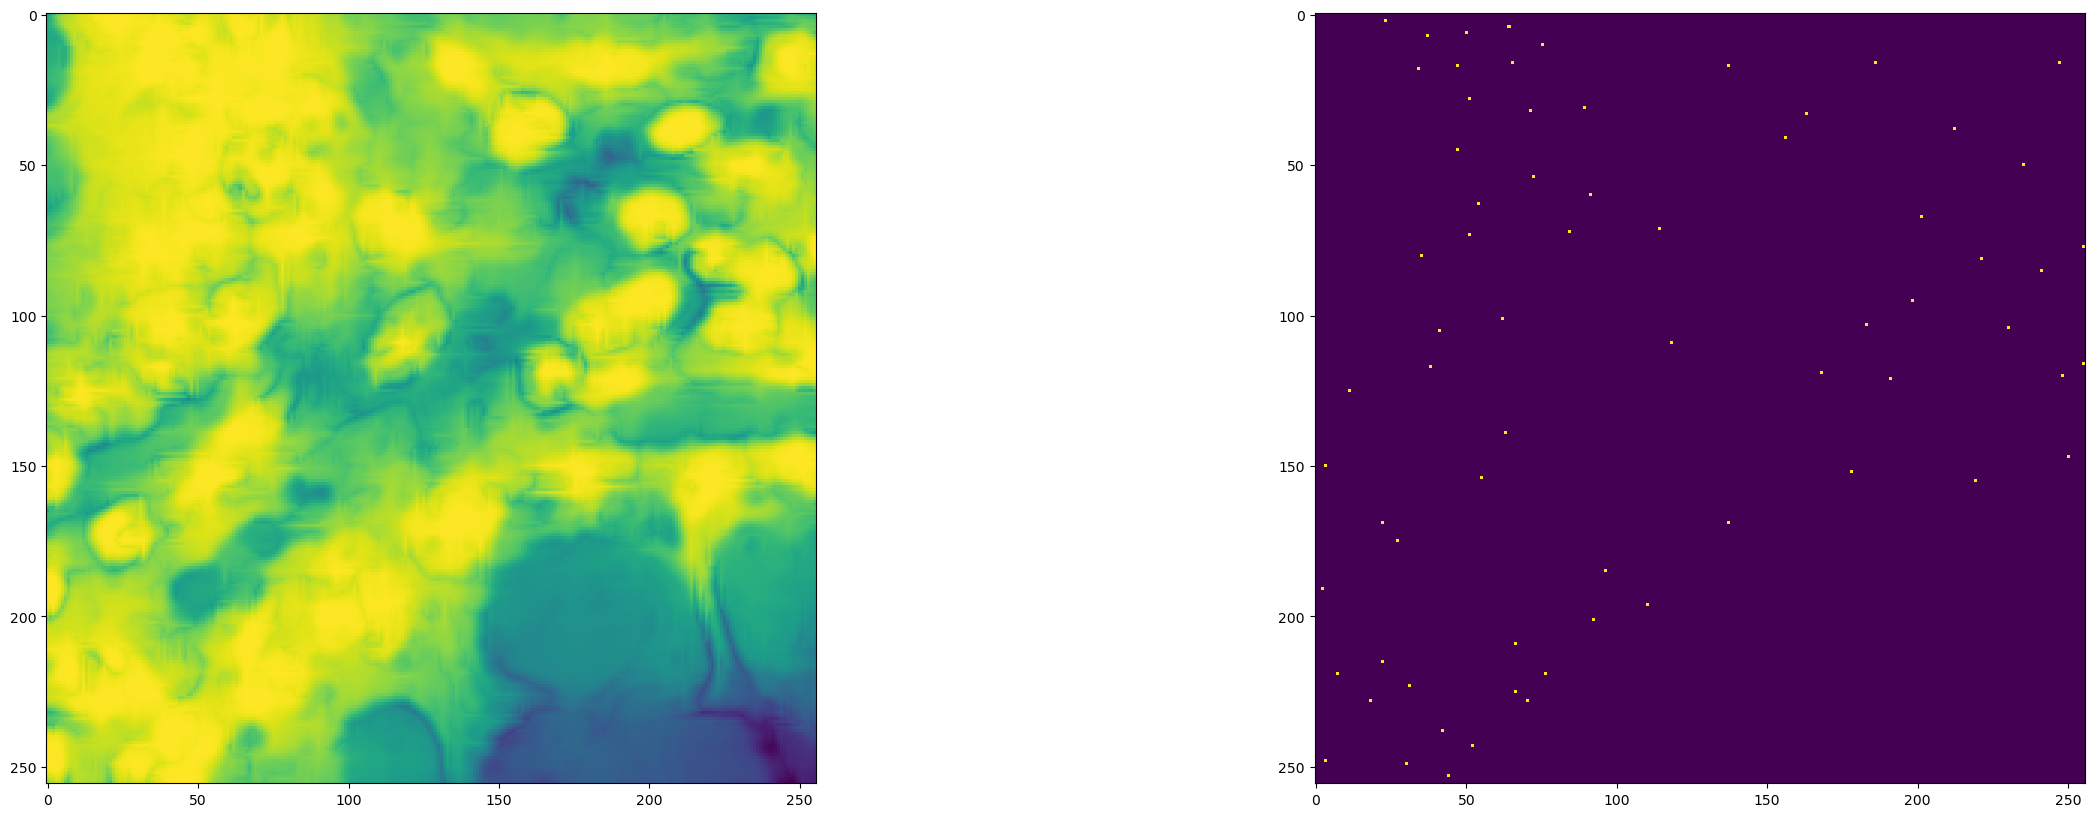

In [ ]:
fig,axes = plt.subplots(1,2, figsize=(30,10))

axes[0].imshow(obj)
axes[1].imshow(obj.astype('uint8'))

In [ ]:
test = sio.imread('/data114_1/wzy/MICCAI23/Point-Supervised-Segmentation/CoNSeP/Train/Objs/train_10_0_248.png')

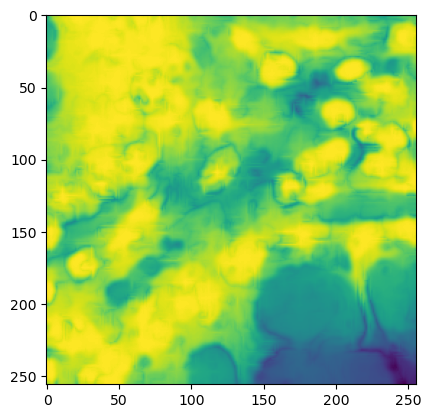

In [ ]:
plt.imshow(test)